## Задание 3 

Обучить СНС с помощью Transfer Learning на датасете Food-101

Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

Библиотеки: [Python, Tensorflow]


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

Загрузка датасета Food-101

In [2]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]', 'validation'],
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompletePZRB0E/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompletePZRB0E/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
labels = open('labels.txt', 'rb').read().decode(encoding='utf-8')

In [5]:
with open('labels.txt', 'r') as f:
    labels = [line.strip() for line in f]
num_classes = len(labels)

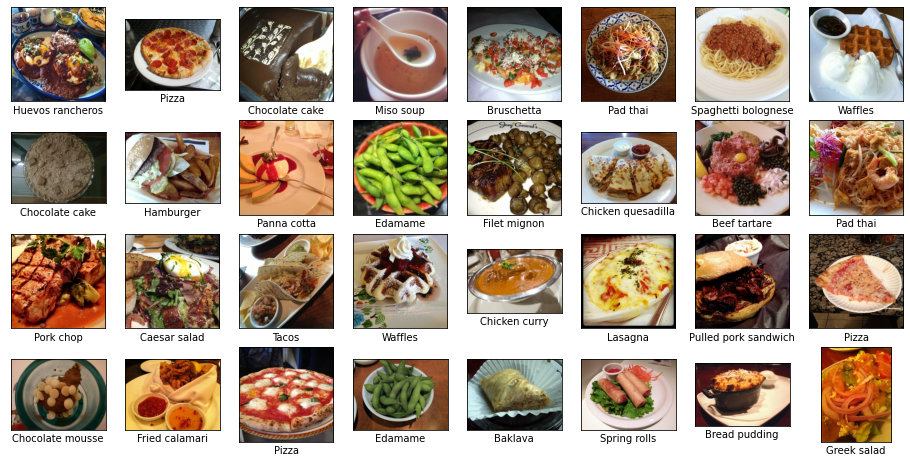

In [6]:
some_samples = [x for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j][0])
    plt.xticks([]), plt.yticks([])
    plt.xlabel(labels[some_samples[j][1]])
plt.show()

Pipeline

In [7]:
INP_SIZE = 224
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

valid_ds = valid_ds.shuffle(buffer_size=1000)
valid_ds = valid_ds.map(prepare)
valid_ds = valid_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

Модель CNN с аугментацией

In [8]:
img_augmentation = Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.15),
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
])



base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))

inputs = layers.Input(shape=(INP_SIZE, INP_SIZE, 3))
x = img_augmentation(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# fix train, not learning first layers
for layer in base_model.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_model = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, 
    name='sparse_categorical_crossentropy'
)

model.compile(optimizer=optimizer,
              loss=loss_model,
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min',
                                                    restore_best_weights=True)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381

Обучение модели

In [11]:
%%time

history = model.fit(
    train_ds,
    epochs=150,
    validation_data=valid_ds,
    callbacks=[early_stopping])

Epoch 1/150
2130/2130 [==============================] - 268s 119ms/step - loss: 2.5230 - accuracy: 0.3938 - val_loss: 1.8964 - val_accuracy: 0.5187
Epoch 2/150
2130/2130 [==============================] - 229s 107ms/step - loss: 2.1449 - accuracy: 0.4735 - val_loss: 1.8355 - val_accuracy: 0.5343
Epoch 3/150
2130/2130 [==============================] - 228s 106ms/step - loss: 2.0784 - accuracy: 0.4894 - val_loss: 1.8084 - val_accuracy: 0.5459
Epoch 4/150
2130/2130 [==============================] - 227s 106ms/step - loss: 2.0491 - accuracy: 0.4984 - val_loss: 1.7801 - val_accuracy: 0.5479
Epoch 5/150
2130/2130 [==============================] - 246s 115ms/step - loss: 2.0325 - accuracy: 0.5001 - val_loss: 1.7639 - val_accuracy: 0.5550
Epoch 6/150
2130/2130 [==============================] - 225s 105ms/step - loss: 2.0244 - accuracy: 0.5020 - val_loss: 1.7973 - val_accuracy: 0.5514
Epoch 7/150
2130/2130 [==============================] - 224s 104ms/step - loss: 2.0188 - accuracy: 0.5036

In [12]:
%%time

model.evaluate(test_ds)

197/197 [==============================] - 73s 349ms/step - loss: 1.5207 - accuracy: 0.5955
CPU times: user 2min 5s, sys: 5.62 s, total: 2min 11s
Wall time: 1min 22s


[1.5207003355026245, 0.5955345630645752]

Модель CNN без аугментации

In [13]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(101, activation='softmax')(x)


model2 = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# fix train, not learning first layers
for layer in base_model.layers:
    layer.trainable = False

In [14]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_model = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, 
    name='sparse_categorical_crossentropy'
)

model2.compile(optimizer=optimizer,
              loss=loss_model,
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min',
                                                    restore_best_weights=True)

In [15]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [16]:
%%time

history2 = model2.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[early_stopping])

Epoch 1/150
2130/2130 [==============================] - 221s 102ms/step - loss: 2.1941 - accuracy: 0.4616 - val_loss: 1.7613 - val_accuracy: 0.5540
Epoch 2/150
2130/2130 [==============================] - 218s 102ms/step - loss: 1.7210 - accuracy: 0.5609 - val_loss: 1.7288 - val_accuracy: 0.5653
Epoch 3/150
2130/2130 [==============================] - 218s 102ms/step - loss: 1.6021 - accuracy: 0.5868 - val_loss: 1.7395 - val_accuracy: 0.5720
Epoch 4/150
2130/2130 [==============================] - 237s 111ms/step - loss: 1.5358 - accuracy: 0.6022 - val_loss: 1.7228 - val_accuracy: 0.5681
Epoch 5/150
2130/2130 [==============================] - 217s 101ms/step - loss: 1.4984 - accuracy: 0.6076 - val_loss: 1.7156 - val_accuracy: 0.5755
Epoch 6/150
2130/2130 [==============================] - 218s 102ms/step - loss: 1.4722 - accuracy: 0.6142 - val_loss: 1.7384 - val_accuracy: 0.5773
Epoch 7/150
2130/2130 [==============================] - 217s 101ms/step - loss: 1.4471 - accuracy: 0.6183

In [17]:
%%time

model.evaluate(test_ds)

197/197 [==============================] - 71s 349ms/step - loss: 1.5219 - accuracy: 0.5955
CPU times: user 2min 3s, sys: 5.7 s, total: 2min 9s
Wall time: 1min 21s


[1.5218505859375, 0.5954552888870239]

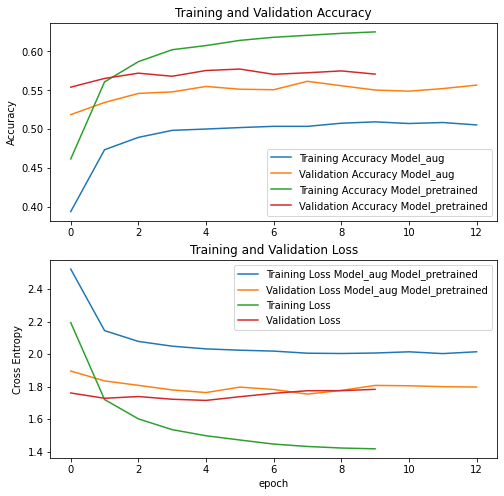

In [18]:
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']

loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc1, label='Training Accuracy Model_aug')
plt.plot(val_acc1, label='Validation Accuracy Model_aug')
plt.plot(acc2, label='Training Accuracy Model_pretrained')
plt.plot(val_acc2, label='Validation Accuracy Model_pretrained')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss1, label='Training Loss Model_aug Model_pretrained')
plt.plot(val_loss1, label='Validation Loss Model_aug Model_pretrained')
plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Запуск предсказания на изображении

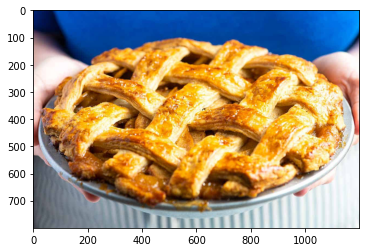

In [22]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

img = imageio.imread('pie.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [23]:
pred = model2(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('Prediction: {}'.format(ds_info.features['label'].int2str(pred_label)))

Prediction: apple_pie


Модель отработала верно.